# Classiq Chemistry Application

This tutorial presents the functionality of Classiq's Chemistry application module. The application is based on the OpenFermion package [[1](#OF)], which is a comprehensive library for defining and analyzing Fermionic systems, in particular quantum chemistry problems. It provides efficient tools for transforming Fermionic operators to Pauli operators, which are then can be used with Qmod to define quantum algorithms (for more details see their [OpenFermion intro tutorial](https://quantumai.google/openfermion/tutorials/intro_to_openfermion) [[2](#OFintro)]).

The different classes and functions of Classiq's chemistry application is demonstrated below by implementing a Variational Quantum Eigensolver (VQE). A collection of concrete and concise VQE and QPE examples for chemistry can be found in the [chemistry application directory](https://github.com/Classiq/classiq-library/tree/main/applications/chemistry).

***
## The `FermionHamiltonianProblem` class: Defining an Electronic structure problem.

There are two ways of defining an electronic structure problem, either providing `MolecularData` of a molecule, or by directly defining a Fermionic Hamiltonian together with the number of spin up/down ($\alpha/\beta$) particles. Below we demonstrate the former, which is a more practical usecase. For the direct definition see [this](https://github.com/Classiq/classiq-library/blob/main/applications/chemistry/second_quantized_hamiltonian/second_quantized_hamiltonian.ipynb) example.
***

### Defining a molecule

We start with defining a molecule, specifying its geometry (elements and their 3D position), multiplicity ($2\cdot(\text{total spin})+1$), basis, and an optional string for its description. In this tutorial we focus on the LiH molecule. There are several ways to get geometry of molecules, typical way involves using the *SMILES* (Simplified Molecular Input Line Entry System) of a molecule and use a chemical package such as `RDkit` to extract the geometry as an `xyz` file (a code example is given in the Appendix A of this notebook). For simplicity, we store the geometry in advance in the `lih.xyz` file and load it.

*Comment: For complex molecules it is possible to call directly `from openfermion.chem import geometry_from_pubchem`*

In [1]:
import pathlib

from openfermion.chem import MolecularData

path = (
    pathlib.Path(__file__).parent.resolve()
    if "__file__" in locals()
    else pathlib.Path(".")
)
geometry_file = path / "lih.xyz"

# Set up molecule parameters
basis = "sto-3g"  # Basis set
multiplicity = 1  # Singlet state S=0
charge = 0  # Neutral molecule

# geometry
with open(geometry_file, "r") as f:
    lines = f.readlines()
    atom_lines = lines[2:]  # skip atom count and comment
    geometry = []
    for line in atom_lines:
        parts = line.strip().split()
        symbol = parts[0]
        coords = tuple(float(x) for x in parts[1:4])
        geometry.append((symbol, coords))

print(geometry)
description = "LiH"

# Create MolecularData object
molecule = MolecularData(geometry, basis, multiplicity, charge, description)

[('Li', (0.833472, 0.0, 0.0)), ('H', (-0.833472, 0.0, 0.0))]


Next, we run a pyscf plugin for calculating various objects for our molecule problem, such as the second quantized Hamiltonian that is at the core of the VQE algorithm. For small problems, we can also get the Full Configuration Interaction (FCI), which calculates classically the ground state energy, i.e., for validating our quantum approach.

*Comment: For complex problems running pyscf can take time, it is possible to run it only once, and load the data later on, using the `save` and `load` methods*.

In [2]:
from openfermionpyscf import run_pyscf

RECALCULATE_MOLECULE = True  # can be set to False after initial run
if RECALCULATE_MOLECULE:
    molecule = run_pyscf(
        molecule,
        run_mp2=True,
        run_cisd=True,
        run_ccsd=True,
        run_fci=True,  # relevant for small, classically solvable problems
    )
    molecule.save()

molecule.load()

Now we can get several properties of our molecular problem. The electronic structure problem is described as a second quantized Hamiltonian
$$
\Large H = h_0 + \sum_{p,q=0}^{2N-1} h_{pq}\, a^\dagger_p a_q + \frac{1}{2} \sum_{p,q,r,s=0}^{2N-1} h_{pqrs} \, a^\dagger_p a^\dagger_q a_r a_s,
\tag{1}
$$
where $h_0$ is a constant nuclear repulsion energy, and $h_{pq}$ and $h_{pqrs}$ are the well-known one-body and two-body molecular integrals, respectively. The sum is over all spin orbitals, which is twice the number of spatial orbitals $N$, as for each spatial orbital we have a spin up and spin down space (also known, and refer hereafter, as $\alpha$ and $\beta$ particles). This, together with the number of free electrons that can occupy those orbitals, define the electronic structure problem.

In [3]:
print(
    f"The electronic structure problems has {2*molecule.n_orbitals} spin orbitals, and we need to occupy {molecule.n_electrons} electrons."
)
print(f"The spatial orbitals energies are: {molecule.orbital_energies}")

The electronic structure problems has 12 spin orbitals, and we need to occupy 4 electrons.
The spatial orbitals energies are: [-2.35046066 -0.27949547  0.07757097  0.16391248  0.16391248  0.52864126]


### Defining a reduced problem (active space/freeze core)

In some cases, we can "freeze" some of the orbitals, occupying them with both spin up and spin down electrons. This will be orbitals with very low energy, such as the core orbitals, which are expected to be "classically" (with both spin up and down) occupied.  In addition, we can exclude orbitals with very high energies, as they are unlikely to contribute significantly to the ground state. In other words, we can choose the active space for our molecular problem --- the spatial orbitals that are relevant to the quantum problem. This of-course reduces the problem we need to tackle.


Below we define a `FermionHamiltonianProblem` for the LiH molecule, freezing its core ($0^{\rm th}$) orbital. The updated number of spatial orbitals and electrons are a property of the class.

In [4]:
from classiq.applications.chemistry.problems import FermionHamiltonianProblem

# Define a FermionHamiltonianProblem in an active space
first_active_index = 1
problem = FermionHamiltonianProblem.from_molecule(
    molecule=molecule,
    first_active_index=first_active_index,  # freeze orbitals below the first index
    remove_orbitlas=[],  # remove orbitals
)

print(f"Reduced number of spatial orbitals after freeze core: {problem.n_orbitals}")
print(
    f"Reduced number of (alpha,beta) electrons after freeze core: {problem.n_particles}"
)

print(
    f"Length of Hamiltonian in Fermionic representation: {len(problem.fermion_hamiltonian.terms)}"
)

Reduced number of spatial orbitals after freeze core: 5
Reduced number of (alpha,beta) electrons after freeze core: (1, 1)
Length of Hamiltonian in Fermionic representation: 811


Let us look at several terms of our Fermionic operator:

In [5]:
print(*list(problem.fermion_hamiltonian.terms.items())[:5], sep="\n")
print(*list(problem.fermion_hamiltonian.terms.items())[::-1][:5], sep="\n")

((), -6.817329071667983)
(((0, 1), (0, 0)), -0.7621826148518264)
(((0, 1), (1, 0)), 0.049739077075891036)
(((0, 1), (4, 0)), -0.12350856641975391)
(((5, 1), (5, 0)), -0.7621826148518264)
(((9, 1), (9, 1), (9, 0), (9, 0)), 0.22555659839798667)
(((9, 1), (9, 1), (9, 0), (6, 0)), -0.022199146730809072)
(((9, 1), (9, 1), (9, 0), (5, 0)), 0.06490533159641326)
(((9, 1), (9, 1), (8, 0), (8, 0)), 0.00990347751080244)
(((9, 1), (9, 1), (7, 0), (7, 0)), 0.00990347751080244)


We can see one-body terms $((i,1),(j,0))$ that refer to $a_i^{\dagger}a_j$, and two-body terms $((i,1),(j,1),(k,0),(l,0))$ that corresponds to $a_i^{\dagger}a_j^{\dagger}a_ka_l$.

<div style="background-color:#f0f8ff; border-left: 5px solid #0077cc; padding: 10px;">
<strong> Orbital labeling: </strong> For $N$ spatial orbitals we have $N_\alpha (\text{spin up})+N_\beta (\text{spin down})=2N$ electron orbitals. The Classiq object for the electronic structure problem is defined according to block spin labeling $(0_\uparrow, 1_\uparrow, \dots, (N-1)_\uparrow, 0_\downarrow,1_\downarrow\dots, (N-1)_\downarrow$). This is opposed to the OpenFermion conventions, that has alternating spin labeling $(0_\uparrow, 0_\downarrow, 1_\uparrow, 1_\downarrow,\dots, (N-1)_\uparrow, (N-1)_\downarrow$). When transforming the problem to a Qubit Hamiltonian, described by Pauli strings, different labeling conventions can result in different Hamiltonians, which in turn, might  lead to different quantum circuits in terms of depth or cx-counts.
</div>


***
## The `FermionToQubitMapper` class: From Fock space to Qubit space
***

<!-- In this part we define the following transformations:
$$
\large \text{Fermionic Fock space}\xrightarrow{\text{JW}} \text{Hilbert space for qubits} \xrightarrow{\text{Clifford transformation}} \text{eigenspace of } \mathbb{Z}_2 \text{ symmetries} \xrightarrow{\text{tapering}} \text{Reduced space},
$$
where JW stands for the Jordan-Wigner transform. -->

### Transforming to Qubit Hamiltonian (Pauli strings)

Typically, when dealing with Fock space operators we need to transform the creation/annihilation operators to Pauli operators, suitable for quantum algorithms. There are several known transforms, such as Jordan Wigner (JW) and Bravyi Kitaev (BK) transforms.

In [6]:
from classiq.applications.chemistry.mapping import FermionToQubitMapper, MappingMethod

mapper = FermionToQubitMapper(method=MappingMethod.JORDAN_WIGNER)

qubit_hamiltonian = mapper.map(problem.fermion_hamiltonian)
qubit_hamiltonian.compress(abs_tol=1e-13)  # trimming

print(f"Length of Hamiltonian in Pauli representation: {len(qubit_hamiltonian.terms)}")
print("Example of Pauli Hamiltonian terms:")
print(*list(qubit_hamiltonian.terms.items())[:5], sep="\n")

Length of Hamiltonian in Pauli representation: 276
Example of Pauli Hamiltonian terms:
((), -5.750184614764152)
(((0, 'Z'),), -0.29670485079927406)
(((0, 'Y'), (1, 'Y')), -0.0025472629069889555)
(((0, 'X'), (1, 'X')), -0.0025472629069889555)
(((0, 'Y'), (1, 'Z'), (2, 'Z'), (3, 'Z'), (4, 'Y')), -0.01778020141438094)


### Hartree Fock state

Once we have a problem and a mapper in hand, we can construct some quantum primitives. One example is the Hartree Fock state, typically used as an initial condition for ground state solvers. For the Jordan Wigner or the Bravyi Kitaev transforms, the Hartree Fock state, which is an elementary basis state in the Fock space, is mapped into a single computational basis state. This state can be determined using the  `get_hf_state` function.

<!-- The Hartree Fock state refers to excitation of all the lower energy orbitals,  -->

<!-- . We In OpenFermion notation, these refer to the lowest orbital indices. Thus, if we have $M$ free electrons, we just excite the first $M$ states. This is captured by operating on the zero state with the operator -->
<!-- $$ -->
<!-- H_{\rm HF} = \Pi^{M}_{i=0} a^{\dagger}_{i}. -->
<!-- $$ -->



In [7]:
from classiq.applications.chemistry.hartree_fock import get_hf_state

hf_state = get_hf_state(problem, mapper)
print(f"The HF state: {''.join(['1' if val else '0' for val in hf_state])}")

The HF state: 1000010000


<div style="background-color:#f0f8ff; border-left: 5px solid #0077cc; padding: 10px;">
<strong> HF state under the JW transform: :</strong> Working with the JW transform, there is a simple relation between the original Fock (occupation number) and transformed (computational) basis states: the state $|\underbrace{0\dots 0}_{k-1}10\dots 0\rangle$ corresponds to occupation of the $k$-th spin orbital in both spaces. Therefore, the Hartree Fock state under this transformation is the string $|\underbrace{1\dots 1}_{N_{\alpha}}00\dots 0\underbrace{1\dots 1}_{N_{\beta}}0\dots 0\rangle$. (This is as opposed to the BK transform, that gives a different computational basis state).
</div>


***
## The `Z2SymTaperMapper` class: From Fock space to reduced Qubit space by using symmetries 
***

Using symmetries of the second quantized Hamiltonian, one can reduce the number of qubits representing the problem by removing (tapering) qubits.
The theory of qubit tapering is broad and complex, see for example Refs [[3](#sym1)] and [[4](#sym2)]. The `Z2SymTaperMapper` defines a mapper that includes qubit tapering. It can be initialized by providing $\mathbb{Z}_2$ symmetries data (set of generators and Pauli $X$ operators) explicitly, or by providing a Fermionic Hamiltonian problem. In the latter case, that is introduced below, the $\mathbb{Z}_2$ symmetries are deduced from the problem Hamiltonian. This is done via the `from_problem` method.

**In the following section we provide some mathematical explanation of what is happening behind the secens when defining the `Z2SymTaperMapper`. All the logic presented below is incorporated as part of this class. The advanced reader is encouraged to follow this part, while less experienced readers may choose to skip ahead to the *Constructing a VQE* section without loss of continuity.**

### Reducing the problem size with $\mathbb{Z}_2$ symmetries (qubit tapering)

The main steps of qubit tapering is as follows (see some technical details in Appendix B at the end of this notebook):

1. Find generators $\left\{g^{(i)}\right\}^k_{i=1}$ for a group of operators that commute with the Hamiltonian $H$: for all $g\in \langle g^{(1)},\dots g^{(k)}\rangle$, $\left[H, g\right] = 0$. That means that there is a basis in which both $H$ and such $g$ operators are diagonal. These operators are assumed to be a single Pauli string, typically containing only Pauli $Z$ operators.
2. Find a unitary transformation $U$ that diagonalizes all $g^{(i)}$, such that each generator operates trivially on all qubits except one, e.g., they transform to operators of the form $X_{l}$ for some qubit number $l$. It can be shown that such unitary can be constructed as $\Pi^k_{i=1}\frac{1}{\sqrt{2}}\left(X_{m^{(i)}}+g^{(i)}\right)$, where $X_{m^{(i)}}$ is operating on a some single qubit $m^{(i)}$.
3. Apply the transformation $U^{\dagger} H U$, whose eigenspace will be identical to those of $U^{\dagger} g_i U$. That means that on some qubits the transformed Hamiltonian is acting trivially, returning $\pm 1$ (thus is the name $\mathbb{Z}_2$ symmetries), and we can taper them off.
4. Taper off qubits from the transformed Hamiltonian.

Let us define a qubit tapering mapper and inspect its properties:

In [8]:
from classiq.applications.chemistry.z2_symmetries import Z2SymTaperMapper

z2taper_mapper = Z2SymTaperMapper.from_problem(
    problem, method=MappingMethod.JORDAN_WIGNER
)

generators = z2taper_mapper.generators
x_ops = z2taper_mapper.x_ops

We can verify that the generators are indeed commuting with the Hamiltonian

In [9]:
from openfermion.utils import commutator

print(f"Number of generators: {len(generators)}")
for gen in generators:
    print(
        f"For generator {gen}: the Norm of commutator with the Hamiltonian {commutator(qubit_hamiltonian, gen).induced_norm(1)}"
    )

Number of generators: 4
For generator 1.0 [Z0 Z1 Z2 Z3 Z4]: the Norm of commutator with the Hamiltonian 0.0
For generator 1.0 [Z2 Z7]: the Norm of commutator with the Hamiltonian 0.0
For generator 1.0 [Z3 Z8]: the Norm of commutator with the Hamiltonian 0.0
For generator 1.0 [Z2 Z3 Z5 Z6 Z9]: the Norm of commutator with the Hamiltonian 0.0


The generators for the symmetry group $\left\{g^{(i)}\right\}$ are accompained by $\left\{X_{m^{(i)}}\right\}$ operators, such that $g^{(i)} X_{m^{(j)}}= (-1)^{\delta_{ij}} X_{m^{(j)}}g^{(i)} $. We can verify this as well:

In [10]:
print(f"The set of Pauli X operators: {[list(op.terms.keys()) for op in x_ops]}")
print("=" * 65)
for pauli_x in x_ops:
    x_position = list(pauli_x.terms.keys())[0][0][0]
    for j in range(len(generators)):
        print(
            f"For Pauli X_{x_position} and generator {j}: the commutator reads {commutator(pauli_x, generators[j])}"
        )

The set of Pauli X operators: [[((0, 'X'),)], [((7, 'X'),)], [((8, 'X'),)], [((5, 'X'),)]]
For Pauli X_0 and generator 0: the commutator reads -2j [Y0 Z1 Z2 Z3 Z4]
For Pauli X_0 and generator 1: the commutator reads 0
For Pauli X_0 and generator 2: the commutator reads 0
For Pauli X_0 and generator 3: the commutator reads 0
For Pauli X_7 and generator 0: the commutator reads 0
For Pauli X_7 and generator 1: the commutator reads -2j [Z2 Y7]
For Pauli X_7 and generator 2: the commutator reads 0
For Pauli X_7 and generator 3: the commutator reads 0
For Pauli X_8 and generator 0: the commutator reads 0
For Pauli X_8 and generator 1: the commutator reads 0
For Pauli X_8 and generator 2: the commutator reads -2j [Z3 Y8]
For Pauli X_8 and generator 3: the commutator reads 0
For Pauli X_5 and generator 0: the commutator reads 0
For Pauli X_5 and generator 1: the commutator reads 0
For Pauli X_5 and generator 2: the commutator reads 0
For Pauli X_5 and generator 3: the commutator reads -2j [Z2 

<div style="background-color:#f0f8ff; border-left: 5px solid #0077cc; padding: 10px;">
<strong> Intuition for conserved quantities under the JW transform: </strong>  In electronic structure problems we have, for example, particle number conservation, spin conservation, and number of particles with fixed spin orientation. The latter corresponds to the two Fermionic operators:
$$
\text{Total number of spin-up/down particles operator:} \qquad N_{\uparrow} = \sum_i a^{\dagger}_{i\uparrow} a_{i\uparrow}, \qquad 
N_{\downarrow} = \sum_i a^{\dagger}_{i\downarrow} a_{i\downarrow}.
$$
As explained in the previous info box, working with the JW transform gives that Fock basis state are trasformed to the computational basis states. In particular, there is a relation between the orbital number operator and the $Z$ operators: $n_i \equiv a_i^{\dagger}a_i = \frac{1}{2}\left(1-Z_i\right)$. We cannot use the transformation of $N_{\uparrow(\downarrow)}$ as our symmetry generators, since they correspond to a sum of Pauli strings rather than a single string. However, we can use any function of those, for example $g_{\uparrow(\downarrow)} = e^{\pi i \hat{N}_{\uparrow(\downarrow)}}$, which, up to a global phase, gives the generators
$$
g_{\uparrow} = \Pi^{N/2-1}_{k=0}Z_{k}, \qquad g_{\downarrow} = \Pi^{N-1}_{k=N/2}Z_{k}.
$$
We can see that $g_{\uparrow}$ is indeed a generator in the example above.
</div>


Next, we can define a transformation from the generators the the Pauli $X$ operators, which means that it block-diagonalizes the Hamiltonian according to symmetry subspaces. This unitary is given by $U = \Pi^k_{i=1}\frac{1}{\sqrt{2}}\left(X_{m^{(i)}}+g^{(i)}\right)$.

In [11]:
from openfermion import QubitOperator

blk_diagonalizing_op = QubitOperator(())
for gen, x_op in zip(generators, x_ops):
    blk_diagonalizing_op *= (2 ** (-0.5)) * (x_op + gen)

Let us verify, for example, that indeed this diagonalizing operator map each generator into a single computational basis subspace:

In [12]:
for gen, x_op in zip(generators, x_ops):
    print(
        f"Generator in the new basis: {blk_diagonalizing_op*gen*blk_diagonalizing_op} --- compared to: {x_op}"
    )

Generator in the new basis: (1.0000000000000002+0j) [X0] --- compared to: 1.0 [X0]
Generator in the new basis: (1.0000000000000002+0j) [X7] --- compared to: 1.0 [X7]
Generator in the new basis: (1.0000000000000002+0j) [X8] --- compared to: 1.0 [X8]
Generator in the new basis: (1.0000000000000002+0j) [X5] --- compared to: 1.0 [X5]


Next, let us examine the block-diagonalized Hamiltonian--- We shall see that after transformation, the Hamiltonian acts trivially on some of the qubits, with the identity or with the $\left\{X_{m^{(i)}}\right\}$ operators found above. Thus, we can reduce it by going to one of the two eigenspaces of these operators, with eigenvalues $\pm 1$.

In [13]:
block_diagonal_hamiltonian = (
    blk_diagonalizing_op * qubit_hamiltonian * blk_diagonalizing_op
)
block_diagonal_hamiltonian.compress(1e-12)
print("Example of Pauli Hamiltonian terms:")
print(*list(block_diagonal_hamiltonian.terms.items())[:16], sep="\n")

Example of Pauli Hamiltonian terms:
((), -5.750184614764152)
(((0, 'X'), (1, 'Z'), (2, 'Z'), (3, 'Z'), (4, 'Z')), -0.2967048507992741)
(((1, 'X'), (2, 'Z'), (3, 'Z'), (4, 'Z')), 0.002547262906988957)
(((0, 'X'), (1, 'X')), -0.002547262906988957)
(((4, 'X'),), 0.017780201414380945)
(((0, 'X'), (1, 'Z'), (2, 'Z'), (3, 'Z'), (4, 'X')), -0.017780201414380945)
(((2, 'Z'), (3, 'Z'), (5, 'X'), (6, 'Z'), (9, 'Z')), -0.2967048507992741)
(((2, 'Z'), (3, 'Z'), (6, 'X'), (9, 'Z')), 0.002547262906988951)
(((5, 'X'), (6, 'X')), -0.002547262906988951)
(((7, 'X'), (8, 'X'), (9, 'X')), 0.017780201414380938)
(((2, 'Z'), (3, 'Z'), (5, 'X'), (6, 'Z'), (7, 'X'), (8, 'X'), (9, 'X')), -0.017780201414380938)
(((1, 'Z'),), -0.39063013875079544)
(((1, 'Y'), (2, 'Z'), (3, 'Z'), (4, 'Y')), 0.024546035949578163)
(((1, 'X'), (2, 'Z'), (3, 'Z'), (4, 'X')), 0.024546035949578163)
(((6, 'Z'),), -0.39063013875079533)
(((2, 'Z'), (3, 'Z'), (6, 'Y'), (7, 'X'), (8, 'X'), (9, 'Y')), 0.024546035949578177)


We can see that on the 0$^{th}$ qubit we have only $X$ operations, therefore, we know that the eigenstates of our Hamiltonian will be of the form:
$$
|\psi\rangle_{10} = |\pm 1\rangle |\bar{\psi}\rangle_{9}.
$$
That is, the first qubit is either at state $|+\rangle$ or $|-\rangle$ (the eigenvectors of the Puali $X$ matrix). The same is true for all the other Pauli $X$ operators in `x_ops`. We shall choose a sector, i.e., the $+1$ or $-1$ subspace, for each of the subspaces $X_{(m_i)}$ operations. 

Which eigenspace to choose?


The answer to this question depends on the problem at hand. If we would like to find the minimal energy of the Hamiltonian, then we shall take the subspace containing the minimal energy. One possibility is to solve multiple ($2^4$) problems on all sectors. However, another approach is to fix the sector according to the HF state, which is assumed to be in the optimal sector with minimal energy. This is the default sector defined in `Z2SymTaperMapper` when initializing with the `.from_problem` method.

To emphasize the effect of choosing different sectors, we construct $2^4$ tapered operators, each for the subspaces (sectors) $\pm 1 \otimes \pm \otimes \pm 1 \otimes \pm 1$, and classically calculate the ground state for each tapered Hamiltonian. 

In [14]:
import itertools

import numpy as np
from openfermion.linalg import get_sparse_operator

for sector in itertools.product([1, -1], repeat=len(x_ops)):
    z2taper_mapper.set_sector(sector)
    tapered_hamiltonian = z2taper_mapper.map(problem.fermion_hamiltonian)
    tapered_hamiltonian_sparse = get_sparse_operator(tapered_hamiltonian)
    w, v = np.linalg.eig(tapered_hamiltonian_sparse.toarray())
    print(f"For sector {sector}: minimal eigenvalue: {np.min(w)}")

For sector (1, 1, 1, 1): minimal eigenvalue: (-7.768908584655453+0j)
For sector (1, 1, 1, -1): minimal eigenvalue: (-7.804992414357773+0j)
For sector (1, 1, -1, 1): minimal eigenvalue: (-7.724554496308053+0j)
For sector (1, 1, -1, -1): minimal eigenvalue: (-7.717412859272543+0j)
For sector (1, -1, 1, 1): minimal eigenvalue: (-7.724554496308075+0j)
For sector (1, -1, 1, -1): minimal eigenvalue: (-7.717412859272538+0j)
For sector (1, -1, -1, 1): minimal eigenvalue: (-7.312750852207606+0j)
For sector (1, -1, -1, -1): minimal eigenvalue: (-7.555931078744113+0j)
For sector (-1, 1, 1, 1): minimal eigenvalue: (-7.8049924143578036+0j)
For sector (-1, 1, 1, -1): minimal eigenvalue: (-7.880416053961544+0j)
For sector (-1, 1, -1, 1): minimal eigenvalue: (-7.717412859272534+0j)
For sector (-1, 1, -1, -1): minimal eigenvalue: (-7.724554496308089+0j)
For sector (-1, -1, 1, 1): minimal eigenvalue: (-7.717412859272531+0j)
For sector (-1, -1, 1, -1): minimal eigenvalue: (-7.724554496308072+0j)
For sect

***
## Constructing a VQE model with Classiq
***

Next, we use all the classical pre-processing and definitions from the previous sections to build, synthesize, and execute a VQE model.
We will take the following steps:
1. Defining the transformed and tapered-off Hartree Fock state, which serves as an initial condition for the problem.
2. Constructing the transformed and tapered-off UCC ansatz.
3. Defining, synthesizing, and executing the full model

As a preliminary step, we define the Hamiltonian of the VQE problem. Since this is the final Hamiltonian (after a series of transformation, from second quantized Hamiltonian, tapering, etc.), let us trim small values according to some rough threshold.

In [15]:
from classiq import *
from classiq.applications.chemistry.op_utils import qubit_op_to_pauli_terms

In [16]:
THRESHOLD = 1e-3

z2taper_mapper = Z2SymTaperMapper.from_problem(problem)

tapered_hamiltonian = z2taper_mapper.map(problem.fermion_hamiltonian, is_invariant=True)
tapered_hamiltonian.compress(THRESHOLD)

n_vqe_qubits = z2taper_mapper.get_num_qubits(problem)
vqe_hamiltonian = qubit_op_to_pauli_terms(tapered_hamiltonian)

print(
    f"Hamiltonian for VQE has: {len(vqe_hamiltonian.terms)} terms, and is operating on {n_vqe_qubits} qubits"
)

Hamiltonian for VQE has: 231 terms, and is operating on 6 qubits


Next, we use Classiq built-in functions to get the Hartree Fock state and the UCC ansatz Hamiltonians, given the problem and mapper.

<div style="background-color:#f0f8ff; border-left: 5px solid #0077cc; padding: 10px;">
<strong> Moving to symmetry subspaces: </strong>  The Hartree Fock and the UCC operators that are defined below do not necessarily have the same symmetries of the molecular Hamiltonian. Thus, after the block-diagonalization, the resulting operators are not restricted to the symmetries' subspaces. We take the following approach: we remove terms which do not satisfy the symmetry relation, i.e., commute with symmetry generators. This is done automatically by calling the corresponding functions.
</div>


### 1. Hartree Fock in the tapered-off space

We have already calculated the HF state under the JW transform, let us find the HF state after qubit tapering:

In [17]:
hf_tapered_state = get_hf_state(problem, z2taper_mapper)
print(f"The HF state: {''.join(['1' if val else '0' for val in hf_tapered_state])}")

The HF state: 000000


### 2. UCC ansatz

The Unitary Coupled Cluster ansatz assumes that the HF state is initially occupied. Then, it includes excitations from the occupied to un-occupied states, where the former is defined by the HF state. In this tutorial we focus on the UCCSD ansatz, in which only singlet and doublet excitation are taken. The corresponding Fermionic operator reads:

$$
\large U_{\text{UCCSD}} \equiv e^{T - T^\dagger}, \qquad T = T_1 + T_2
$$
where:
$$
\large  T_1 = \sum_{i \in \text{occ}} \sum_{a \in \text{virt}} t_i^a a_a^\dagger a_i, \qquad T_2 = \sum_{i<j \in \text{occ}} \sum_{a<b \in \text{virt}} t_{ij}^{ab} a_a^\dagger a_b^\dagger a_j a_i,
$$
and the $t$ terms are parametric angles. The function for obtaining the UCC Hamiltonians takes into account spin conservation.

In [18]:
from classiq.applications.chemistry.ucc import get_ucc_hamiltonians

uccsd_hamiltonians = get_ucc_hamiltonians(problem, z2taper_mapper, excitations=[1, 2])

### 3. Running a VQE

The VQE is constructed by preparing the HF state (with the `prepare_basis_state` function) and evolving a parametric UCCSD Hamiltonian with Suzuki Trotter.

In [19]:
import matplotlib.pyplot as plt

In [20]:
TOL = 0.001
num_params = len(uccsd_hamiltonians)
print(f"Number of parameters: {num_params}")


@qfunc
def main(params: CArray[CReal, num_params], state: Output[QArray]) -> None:
    prepare_basis_state(hf_tapered_state, state)
    multi_suzuki_trotter(
        hamiltonians=uccsd_hamiltonians,
        evolution_coefficients=params,
        order=1,
        repetitions=1,
        qbv=state,
    )


write_qmod(main, "vqe_ucc" + description, symbolic_only=False)
qprog = synthesize(main)
show(qprog)

Number of parameters: 10
Quantum program link: https://platform.classiq.io/circuit/2z2RTcE8Hh6oxpBlHjIDsojFi8p


To get a quick execution, we run on a statevector simulator.

In [21]:
qprog = set_quantum_program_execution_preferences(
    qprog,
    preferences=ExecutionPreferences(
        num_shots=1000,
        backend_preferences=ClassiqBackendPreferences(
            backend_name="simulator_statevector"
        ),
    ),
)

We run simple optimization using the `minimize` method of `ExecutionSession` 

In [22]:
with ExecutionSession(qprog) as es:
    result = es.minimize(
        cost_function=vqe_hamiltonian,
        initial_params={"params": [0] * num_params},
        max_iteration=200,
    )

optimizer result classiq: -7.880416045210553


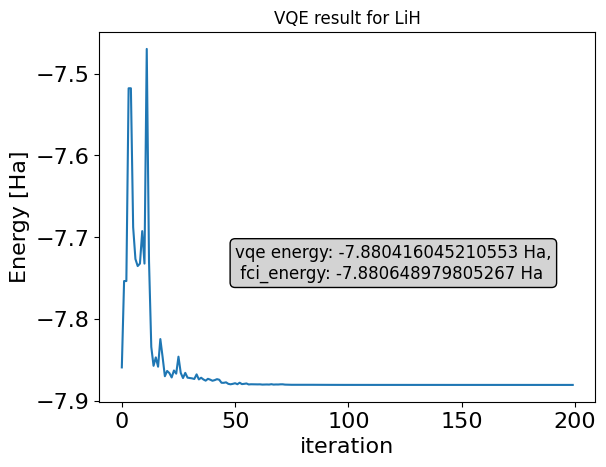

In [23]:
expected_energy = float(molecule.fci_energy)

optimizer_res = result[-1][0]
print(f"optimizer result classiq: {optimizer_res}")

vqe_results = {k: np.real(result[k][0]) for k in range(len(result))}


plt.plot(vqe_results.keys(), vqe_results.values(), "-")
plt.ylabel("Energy [Ha]", fontsize=16)
plt.xlabel("iteration", fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.title("VQE result for " + description)
plt.text(
    50,
    -7.75,
    f"vqe energy: {optimizer_res} Ha,\n fci_energy: {expected_energy} Ha",
    fontsize=12,
    bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round,pad=0.3"),
);

## Appendix A - Loading molecule geometry

```
from rdkit import Chem
from rdkit.Chem import AllChem

# Generate 3D coordinates
mol = Chem.MolFromSmiles('[LiH]')
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)

# Prepare XYZ string
conf = mol.GetConformer()
n_atoms = mol.GetNumAtoms()

xyz_lines = [f"{n_atoms}", "LiH generated by RDKit"]

for atom in mol.GetAtoms():
    idx = atom.GetIdx()
    pos = conf.GetAtomPosition(idx)
    line = f"{atom.GetSymbol()} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}"
    xyz_lines.append(line)

xyz_string = "\n".join(xyz_lines)

# Save to file
with open("lih.xyz", "w") as f:
    f.write(xyz_string)
```

## Appendix B - Techical details on qubit tapering

Below we provide some technical details concerning qubit tapering and $\mathbb{Z}_2$ symmetries.

It is a well-known fact in linear algebra that if two operators commute, $[A,B]=0$, then they can be mutually diagonalized. In particular, if $|v\rangle$ is an eigenvector of $B$ with an eigenvalue $\lambda$, we have
$$
[A,B]=0\implies AB = BA \implies AB|v\rangle = BA|v\rangle \implies \lambda \left(A|v\rangle\right) = B\left(A|v\rangle\right).
$$
That is, $A|v\rangle$ is also an eigenvector of $B$ with eigenvalue $\lambda$. Thus, $A|v\rangle$ must be in the eigenspace $V_{\lambda} \equiv \left\{|u\rangle, B|u\rangle = \lambda|u\rangle\right\}$.

Now, Refs. [[3](#sym1)] and [[4](#sym2)] show, and this is implemented explicitly in Appendix B, that we can find a Clifford transformation $U$, such that the transformed Hamiltonian $H'=U^{\dagger} H U$ commutes with the transformed symmetries $X_{m^{(i)}} = U^{\dagger} g_i U$. We know how the eigenspaces of $X_{m^{(i)}}$ look like. For example, $X_{0}$ has two eigenspaces that correspond to the eigenvalues $\pm 1$: $V_{\pm} = \left\{|u\rangle_N, X_{0}|u\rangle_N = \pm |u\rangle_N\right\} = \left\{|\pm\rangle \otimes |\tilde{u}\rangle_{N-1},\, |\tilde{u}\rangle_{N-1} \text{ some state on } N-1 \text{ qubits}\right\} $. From the arguments above we get that 
$$
H'\cdot \left(|\pm\rangle |u\rangle\right) \in V_{\pm},
$$
which means that $H'$ must acts with $X_0$ or the Identity on the first qubit.

## References

<a name='OF'>[1]</a>: [McClean et. al. Quantum Sci. Technol. 5 034014 (2020). OpenFermion: the electronic structure package for quantum computers.](https://arxiv.org/abs/1710.07629)

<a name='OFintro'>[2]</a>: [Introduction to OpenFermion.](https://quantumai.google/openfermion/tutorials/intro_to_openfermion)

<a name='sym1'>[3]</a>: [Bravyi et. al., arXiv preprint arXiv:1701.08213 (2017). Tapering off qubits to simulate fermionic Hamiltonians.
](https://arxiv.org/abs/1701.08213)

<a name='sym2'>[4]</a>: [Kanav et al. J. Chem. Theo. Comp. 16 10 (2020). Reducing qubit requirements for quantum simulations using molecular point group symmetries.](https://arxiv.org/abs/1910.14644)
